### Cleaning dataset

In [1]:
import yaml

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
try:
    with open('../config.yaml') as file:
        config = yaml.safe_load(file)
except:
    print("Yaml file not found.")

In [3]:
# Load dataset q1
q1_df = pd.read_csv(config['input_data']['q1_dataset'])
q1_df.head()

username  country country_code  question_no          uid  year  \
0  ALB22uFF4m  Albania          ALB            1  q1c1_apjufc  2000   
1  ALB22uFF4m  Albania          ALB            1  q1c1_apjufc  2001   
2  ALB22uFF4m  Albania          ALB            1  q1c1_apjufc  2002   
3  ALB22uFF4m  Albania          ALB            1  q1c1_apjufc  2003   
4  ALB22uFF4m  Albania          ALB            1  q1c1_apjufc  2004   

               answer  value_na  value  
0  Mixed system [0.5]       0.5    0.5  
1  Mixed system [0.5]       0.5    0.5  
2  Mixed system [0.5]       0.5    0.5  
3  Mixed system [0.5]       0.5    0.5  
4  Mixed system [0.5]       0.5    0.5

In [4]:
# Load dataset q2
#q2_df = pd.read_csv(config['input_data']['q2_dataset'])
#q2_df.head()

In [5]:
# Check for missing values (in percentage) 

(q1_cleaned.isna().mean().sort_values(ascending=False)*100).head()

NameError: name 'q1_cleaned' is not defined

In [ ]:
# Decide to drop all questions with more than 20% values missing

columns_nan_percentage = q1_cleaned.isna().mean()*100
columns_nan_20_percent = columns_nan_percentage[columns_nan_percentage > 20].index
columns_nan_20_percent

In [5]:
def cleaning_judicial_autonomy_data(qx_df):

    # Step 1: Create copy of dataframe
    df = qx_df.copy()
    
    # Step 2: Adjust dataframe shape
    # Pivot long dataframe to wide dataframe
    df_pivoted = df.pivot(index=['username', 'country', 'country_code', 'year'], 
                          columns=['uid'], 
                          values=['value'])
    
    # Reset index and flattening multi-level column names
    df_pivoted.reset_index(inplace=True)
    df_pivoted.columns = [col[1] if col[1] else col[0] for col in df_pivoted.columns]

    # Step 3: Clean country and user names
    # Remove usernames
    remove_usernames = ('ADMIN123', 
                        'ALB22uFF4m',
                        'BEL22cEw8t', 
                        'BIH22q2nOU', 
                        'DNK22KFh1N', 
                        'MNE22N8NJv', 
                        'NLD22Ba53p', 
                        'SRB22L4wbh')
    df_countries_cleaned = df_pivoted[~df_pivoted['username'].isin(remove_usernames)]

    # Replace country names
    df_countries_cleaned.loc[:,'country'] = df_countries_cleaned['country'].replace({
        'Czech Republic': 'Czechia',
        'Republic of Albania': 'Albania',
        'Republic of Serbia': 'Serbia',
        'Bosnia and Herzegovina (BiH)': 'Bosnia and Herzegovina',
        'Montenegro (MON)': 'Montenegro',
        'Kingdom of Belgium': 'Belgium'})
    
    # Step 4: Remove columns
    # Drop columns that contain '_subj'
    # Drop columns with more than 20% values missing values ['q1c2_jubonus', 'q1c2_retireage', 'q1c3_evalints', 'q1c3_immunlift']
    columns_nan_percentage = df_countries_cleaned.isna().mean()*100
    columns_nan_20_percent = columns_nan_percentage[columns_nan_percentage > 20].index
    df_cleaned = df_countries_cleaned.drop(columns=columns_nan_20_percent)

    return df_cleaned

In [6]:
q1_cleaned = cleaning_judicial_autonomy_data(q1_df)
#q1_cleaned.to_csv(config['output_data']['q1_dataset'])
#q1_cleaned    

In [ ]:
#q2_cleaned = cleaning_judicial_autonomy_data(q2_df)
#q2_cleaned.to_csv(config['output_data']['q2_dataset'])
#q2_cleaned  

In [7]:
def recoding_fuzzy_values(qx_df):

    df_fuzzy_values_recoded = qx_df.copy()
    float_columns = df_fuzzy_values_recoded.select_dtypes(include=float).columns

    for col in float_columns:
        df_fuzzy_values_recoded[col] = df_fuzzy_values_recoded[col].apply(lambda value: 0.0 if value <= 0.5 else 1.0)

    return df_fuzzy_values_recoded

In [8]:
# Fuzzy values recoded

q1_cleaned_fuzzy_recoded = recoding_fuzzy_values(q1_cleaned)

In [ ]:
q1_cleaned_fuzzy_recoded['q1c1_apjuac'].dtype

### Long version cleaning function

In [ ]:
# Pivot long dataframe to wide dataframe
q1_pivoted = q1_df.pivot(index=['username', 'country', 'country_code', 'year'], 
                      columns=['uid'], 
                      values=['value'])

# Reset index and flattening multi-level column names
# Use lambda function to access tuple storing the multi-level column names
q1_pivoted.reset_index(inplace=True)
q1_pivoted.columns = [col[1] if col[1] else col[0] for col in q1_pivoted.columns]
#q1_pivoted

In [ ]:
# Filter out countries / users
remove_usernames = ('ADMIN123', 'ALB22uFF4m','BEL22cEw8t', 'BIH22q2nOU', 'DNK22KFh1N', 'MNE22N8NJv', 'NLD22Ba53p', 'SRB22L4wbh')
q1_countries_cleaned = q1_pivoted[~q1_pivoted['username'].isin(remove_usernames)]
#q1_countries_cleaned

In [ ]:
# Replace country names
q1_countries_cleaned.loc[:,'country'] = q1_countries_cleaned['country'].replace({
    "Czech Republic": "Czechia",
    "Republic of Albania": "Albania",
    "Republic of Serbia": "Serbia",
    "Bosnia and Herzegovina (BiH)": "Bosnia and Herzegovina",
    "Montenegro (MON)": "Montenegro",
    "Kingdom of Belgium": "Belgium"})
#q1_countries_cleaned

In [ ]:
# Drop columns that contain '_subj' (i.e. subjective answers) + columns with >20% of missing values
q1_subj_cleaned = q1_countries_cleaned.drop(list(q1_countries_cleaned.filter(regex='_subj')), axis=1)
q1_columns_cleaned = q1_subj_cleaned.drop(columns = ['q1c2_retireage', 'q1c2_jubonus', 'q1c3_immunlift', 'q1c3_evalints'])
#q1_subj_cleaned

### Create subsets

In [9]:
def subset_dataset_into_indicators(qx_cleaned):

    subsets = {

    # 1 -- Actors involved in appointment procedures of judges
        'q1_appointment_judges': qx_cleaned[[
                                        'country',
                                        'year',
                                        'q1c1_apjufc',
                                        'q1c1_apjuac',
                                        'q1c1_apjuhc']],
        
    # 2 -- Actors involved in appointment procedures of court presidents
 
        'q1_appointment_court_presidents': qx_cleaned[[
                                        'country',
                                        'year',
                                        'q1c1_appresidfc',
                                        'q1c1_appresidac',
                                        'q1c1_appresidhc']],
    
    # 3 -- Veto powers during appointment procedures
        'q1_appointment_veto': qx_cleaned[[
                                        'country',
                                        'year',
                                        'q1c1_exvetofc',
                                        'q1c1_exvetoac',
                                        'q1c1_exvetohc']],
    
    # 4 -- Selection and appointment criteria for judges - predetermined by law
        'q1_selection_criteria_law': qx_cleaned[[
                                        'country',
                                        'year',
                                        'q1c1_critfclaw', 
                                        'q1c1_critaclaw',
                                        'q1c1_crithclaw']],

    # 5 -- Selection and appointment criteria for judges - in accordance to international standards
        'q1_selection_criteria_standards': qx_cleaned[[
                                        'country',
                                        'year', 
                                        'q1c1_critfcints',
                                        'q1c1_critacints', 
                                        'q1c1_crithcints',
                                        'q1c1_probju']],

    # 6 -- Transparency and mechanisms for appeal in appointment procedures of judges
    'q1_appointment_transparency': qx_cleaned[['country',
                                              'year',
                                              'q1c1_transplaw', 
                                              'q1c1_appealfc',
                                              'q1c1_appealac',
                                              'q1c1_appealhc']],
    # 7 -- Tenure and term in office of judges
    'q1_judge_tenure': qx_cleaned[['country',
                                  'year',
                                  'q1c2_termfcju', 
                                  'q1c2_termacju',
                                  'q1c2_termpresid', 
                                  'q1c2_termhcju']],
    
    # 8 -- Immunity and non-transferability of judges
    'q1_judge_immunity': qx_cleaned[['country',
                                    'year',
                                    'q1c2_juabsimmun', 
                                    'q1c2_jufuncimmun',
                                    'q1c2_juremove', 
                                    'q1c2_jutransf']],

    # 9 -- Salaries and bonuses of judges
    'q1_judge_salary': qx_cleaned[['country',
                                  'year',
                                  'q1c2_jusalary',
                                  'q1c2_jupension']],
        
    # 10 -- Disciplinary proceedings against judges - predetermined by law
    'q1_disciplinary_proceedings_law': qx_cleaned[['country',
                                              'year',
                                              'q1c3_fairtrial', 
                                              'q1c3_disciplaw',
                                              'q1c3_discipints',
                                              'q1c3_sanctscale']],
        
    # 11 -- Disciplinary proceedings against judges - actors involved
    'q1_disciplinary_proceedings_actors': qx_cleaned[['country',
                                              'year',
                                              'q1c3_discipbody',
                                              'q1c3_initdiscip', 
                                              'q1c3_decdiscip',
                                              'q1c3_appealdiscip']],
        
    # 12 -- Conflict of interest, recusal from cases and evaluation of judges
    'q1_conflict_recusal_evaluation': qx_cleaned[['country',
                                          'year',
                                          'q1c3_judisclos', 
                                          'q1c3_jurestrict',
                                          'q1c3_jurecuse']],
                                          
    # 13 -- Composition of the judicial self-governing bodies
    'q1_judicial_self_governance_bodies': qx_cleaned[['country',
                                             'year',
                                             'q1c4_whocharge', 
                                             'q1c4_whoselect',
                                             'q1c4_whochair']], 
        
    # 14 -- Competences and functioning of the judicial self-governing bodies
    'q1_judicial_self_governance_competences': qx_cleaned[['country',
                                             'year',
                                             'q1c4_competence',
                                             'q1c4_sameright', 
                                             'q1c4_reasondecis']], 
    
    # 15 -- Administration, functioning and budget of courts                                         
    'q1_courts_administration': qx_cleaned[['country',
                                           'year',
                                           'q1c4_casealloc', 
                                           'q1c4_regbudget',
                                           'q1c4_manbudget']]
    }

    return subsets
    

In [ ]:
# Create macro-indicator measurement (by mean)

def aggregate_micro_indicators(subsets):

    macro_indicators = {

        # Merge micro-indicators for macro-indicator 'appointment_procedures'
        temporary_merge1 = pd.merge(indicators_mean_subsets_no_nan['q1_appointment_judges'], indicators_mean_subsets_no_nan['q1_appointment_court_presidents'], how='outer', on=['country', 'year'])
        q1_macro_appointment_procedures = pd.merge(temporary_merge1, indicators_mean_subsets_no_nan['q1_appointment_veto'], how='outer', on=['country', 'year'])
        # q1_appointment_transparency

        # Merge micro-indicators for macro-indicator 'professional_rights'
        q1_macro_professional_rights
        # q1_judge_tenure
        # q1_judge_immunity
        # q1_judge_salary



        # Merge micro-indicators for macro-indicator 'professional_obligations'
        q1_macro_professional_obligations

        # q1_disciplinary_proceedings_law
        # q1_disciplinary_proceedings_actors
        # q1_conflict_recusal_evaluation

        
        # Merge micro-indicators for macro-indicator 'judicial_administration'
        q1_macro_judicial_administration
        # q1_judicial_self_governance_bodies
        # q1_judicial_self_governance_competences
        # q1_courts_administration
        



In [14]:
subset_indicators = subset_dataset_into_indicators(q1_cleaned)

In [15]:
subset_indicators_fuzzy_recoded = subset_dataset_into_indicators(q1_cleaned_fuzzy_recoded)

In [16]:
# Function to fill in missing values in each micro-indicator by row mode

def fill_na_with_row_mode(row):
    """
    Step 1: Calculate the mode for the row. If multiple modes, take the first one
    Step 2: Replace NaN values in the row with the mode
    """
    row_numeric = row[2:]
    numeric_modes = row_numeric.mode()
    mode_value = numeric_modes.iloc[0] if not numeric_modes.empty else np.nan

    #mode_value = row_numeric.mode().iloc[0] if not row.mode().empty else np.nan # select_dtypes(include=float)
    return row.fillna(mode_value) 

In [17]:
# Apply function to all micro-indicator subsets

def fill_na_in_micro_indicators(subsets):
    filled_subsets = {}
    for key, subset in subsets.items():
        filled_subset = subset.apply(fill_na_with_row_mode, axis=1)
        filled_subsets[key] = filled_subset
    return filled_subsets
    

In [18]:
# Run function 

filled_subsets = fill_na_in_micro_indicators(subset_indicators)

In [19]:
# Fuzzy values recoded
# Run function 
filled_subsets_fuzzy_recoded = fill_na_in_micro_indicators(subset_indicators_fuzzy_recoded)

In [20]:
# Create micro-indicator measurement (by mean)

def calc_micro_indicators_mean(subsets):
    calc_means_subsets = {}
    for key, subset in subsets.items():
        calc_means_subsets[key] = subset.copy()
        calc_means_subsets[key]['indicators_mean'] = subset.select_dtypes(include=float).mean(axis=1)
        
        #calc_means_subsets[key]['indicators_mean'] = subset.select_dtypes(include=float).apply('mean', axis=1)
       # calc_means_subsets[key]['indicators_mean'] = indicators_mean
    return calc_means_subsets
    

In [ ]:
# Run function

In [22]:
# Micro-indicators means (after filling in NAs with row mode)

indicators_mean_subsets_no_nan = calc_micro_indicators_mean(filled_subsets)
indicators_mean_subsets_no_nan['q1_appointment_judges']['indicators_mean'].value_counts().sort_index(ascending=False)

indicators_mean
1.000000    143
0.833333     89
0.666667     81
0.500000    427
0.333333     19
0.166667     23
0.000000    138
Name: count, dtype: int64

In [21]:
# Micro-indicators means (without filling in NAs with row mode)

indicators_mean_subsets_nan = calc_micro_indicators_mean(subset_indicators)
indicators_mean_subsets_nan['q1_appointment_judges']['indicators_mean'].value_counts().sort_index(ascending=False)

indicators_mean
1.000000    143
0.833333     89
0.666667     81
0.500000    427
0.333333     19
0.250000     23
0.000000    138
Name: count, dtype: int64

In [23]:
# Micro-indicators means (after recoding fuzzy values to binary and filling in NAs with row mode)

indicators_mean_subsets_no_nan_fuzzy_recoded = calc_micro_indicators_mean(filled_subsets_fuzzy_recoded)
indicators_mean_subsets_no_nan_fuzzy_recoded['q1_appointment_judges']['indicators_mean'].value_counts().sort_index(ascending=False)

indicators_mean
1.000000    143
0.666667    112
0.333333     99
0.000000    566
Name: count, dtype: int64

In [136]:
# Plot distribution of values in mean_subsets column

def distribution_of_mean_values(subsets):
    
    # Set the grid size and the figure for subplots
    n_subsets = len(subsets)
    ncols = 5
    nrows = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
    fig.tight_layout(pad=3.0)  # spacing between plots

    # Set title of the plot
    fig.suptitle('Distribution of Mean Values Across Subsets (Q1)', fontsize=16, y=1.025)

    # Flatten axes array for easy indexing, if necessary
    axs = axs.flatten() if n_subsets > 1 else [axs]
    
    # Create a histogram for each subset
    for idx, (key, subset) in enumerate(subsets.items()):
        sns.histplot(subset['indicators_mean'], bins=10, label=key, ax=axs[idx])        
        axs[idx].set_title(f'{key}', fontsize=10) # adjust subplot title
        axs[idx].legend().remove() # remove subplot legend
        axs[idx].set_xlabel('') # remove x-axis label
        axs[idx].set_xticks(np.arange(start=0, stop=1.2, step=0.2)) # adjust ticks on x-axis

    plt.show()


#### Distribution of Measurement for each Micro-Indicator (after filling in NAs with row mode)

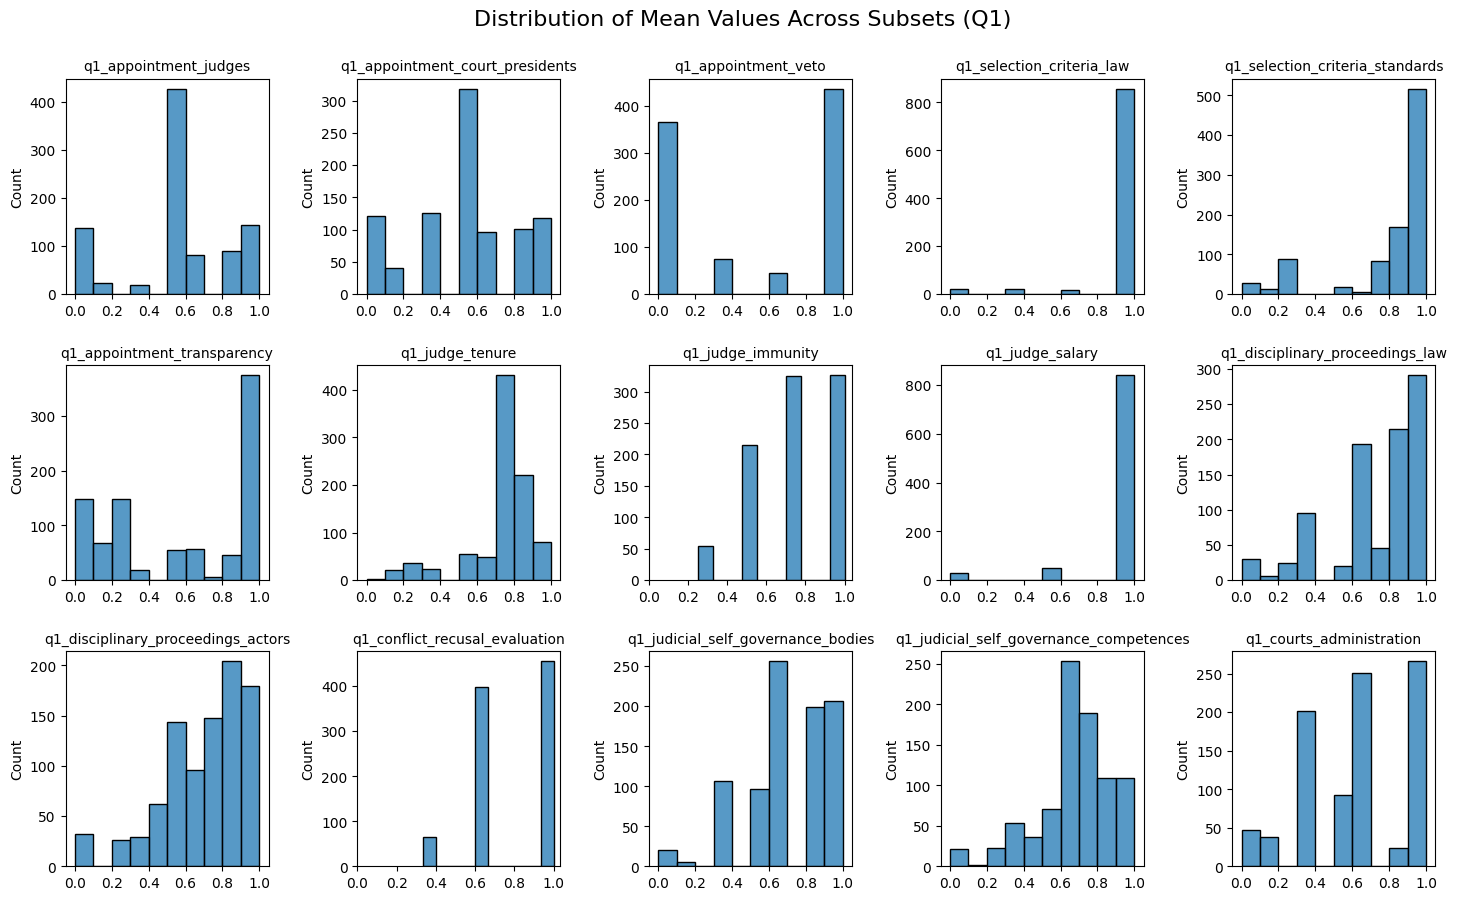

In [133]:
distribution_of_mean_values(indicators_mean_subsets_no_nan)

#### Distribution of Measurement for each Micro-Indicator (without filling in NAs with row mode)

In [134]:
distribution_of_mean_values(indicators_mean_subsets_nan)

#### Distribution of Measurement for each Micro-Indicator (after recoding fuzzy values to binary and filling in NAs with row mode)

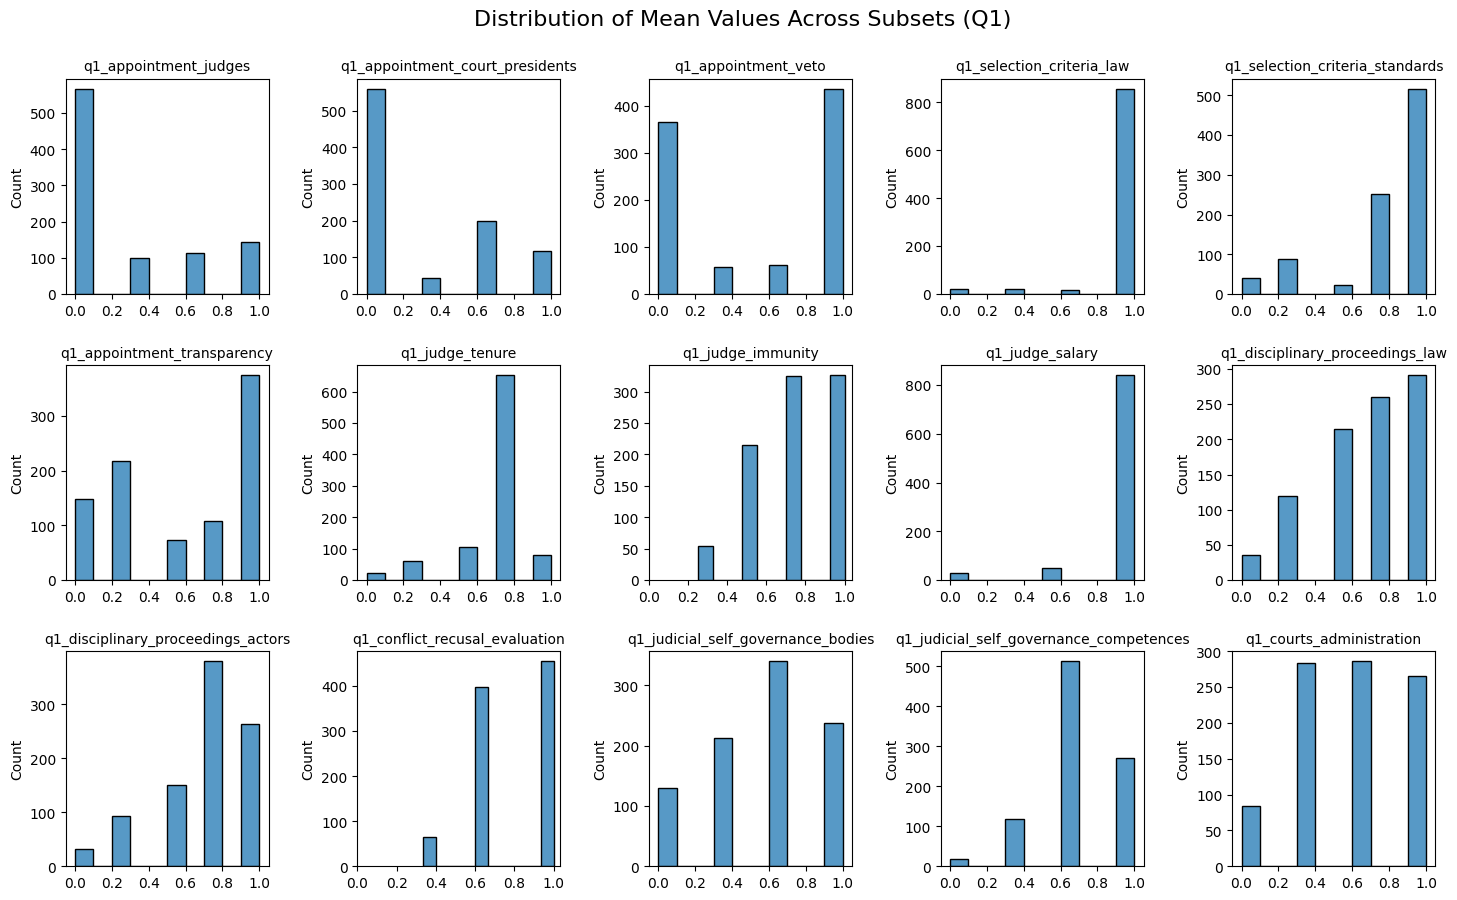

In [135]:
distribution_of_mean_values(indicators_mean_subsets_no_nan_fuzzy_recoded)

In [ ]:
q1_appointment_judges = filled_subsets['q1_appointment_judges']
q1_appointment_court_presidents = filled_subsets['q1_appointment_court_presidents']
q1_appointment_veto = filled_subsets['q1_appointment_veto']
q1_selection_criteria_law = filled_subsets['q1_selection_criteria_law']
q1_selection_criteria_standards = filled_subsets['q1_selection_criteria_standards']
q1_appointment_transparency = filled_subsets['q1_appointment_transparency']
q1_judge_tenure = filled_subsets['q1_judge_tenure']
q1_judge_immunity = filled_subsets['q1_judge_immunity']
q1_judge_salary = filled_subsets['q1_judge_salary']
q1_disciplinary_proceedings_law = filled_subsets['q1_disciplinary_proceedings_law']
q1_disciplinary_proceedings_actors = filled_subsets['q1_disciplinary_proceedings_actors']
q1_conflict_recusal_evaluation = filled_subsets['q1_conflict_recusal_evaluation']
q1_judicial_self_governance = filled_subsets['q1_judicial_self_governance']
q1_judicial_self_governance = filled_subsets['q1_judicial_self_governance']
q1_courts_administration = filled_subsets['q1_courts_administration']

In [12]:
q1_appointment_judges.isna().sum()

country        0
year           0
q1c1_apjufc    0
q1c1_apjuac    0
q1c1_apjuhc    0
dtype: int64

### NOTES

In [23]:
subset_indicators['q1_appointment_actors'].nunique()

country            40
year               23
q1c1_apjufc         3
q1c1_apjuac         3
q1c1_apjuhc         3
q1c1_appresidfc     3
q1c1_appresidac     3
q1c1_appresidhc     3
q1c1_exvetofc       2
q1c1_exvetoac       2
q1c1_exvetohc       2
dtype: int64

In [70]:
import numpy as np
import pandas as pd

def fill_na_with_row_mode2(row):
    """
    Step 1: Calculate the mode for the numerical columns in the row. 
    Step 2: If multiple modes, take the first one
    Step 3: Replace NaN values in the row with the mode
    """
    # Focus on float dtype for mode calculation
    mode_values = row.mode(dropna=True)
    if not mode_values.empty:
        mode_value = mode_values.iloc[0]
    else:
        mode_value = np.nan
    # Replace NaN values in the original row with the mode, return modified row
    return row.fillna(mode_value)

def fill_na_in_micro_indicators2(subsets):
    """
    Apply fill_na_with_row_mode function across subsets in the dictionary to fill NaN
    """
    filled_subsets = {}
    for key, subset in subsets.items():
        # Apply the function row-wise (axis=1)
        filled_subset = subset.apply(fill_na_with_row_mode2, axis=1)
        filled_subsets[key] = filled_subset
    return filled_subsets

In [71]:
filled_subsets = fill_na_in_micro_indicators2(subset_indicators)


C:\Users\Friederike\AppData\Local\Temp\ipykernel_16192\1954133511.py:11: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  mode_values = row.mode(dropna=True)
C:\Users\Friederike\AppData\Local\Temp\ipykernel_16192\1954133511.py:11: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  mode_values = row.mode(dropna=True)
C:\Users\Friederike\AppData\Local\Temp\ipykernel_16192\1954133511.py:11: UserWarning: Unable to sort modes: '<' not supported between instances of 'int' and 'str'
  mode_values = row.mode(dropna=True)


In [20]:
# Apply the function row-wise (axis=1)
q1_appointment_actors_filled = subset_indicators['q1_appointment_actors'].apply(fill_na_with_row_mode, axis=1)
subset_indicators['q1_appointment_actors'].isna().sum(), q1_appointment_actors_filled.isna().sum()

q1_appointment_actors_filled['q1c1_exvetoac'].value_counts()

q1c1_exvetoac
1.0    459
0.0    422
0.5     39
Name: count, dtype: int64

In [31]:
mode_value_test = subset_indicators['q1_appointment_actors'].select_dtypes(include=float).mode().iloc[0]
mode_value_test

q1c1_apjufc        0.5
q1c1_apjuac        0.5
q1c1_apjuhc        0.5
q1c1_appresidfc    0.5
q1c1_appresidac    0.5
q1c1_appresidhc    0.5
q1c1_exvetofc      1.0
q1c1_exvetoac      1.0
q1c1_exvetohc      1.0
Name: 0, dtype: float64

### Check for missing values in each subset

In [35]:
q1_courts_administration.isna().sum().sort_values(ascending=False)

q1c4_casealloc    29
q1c4_manbudget    23
country            0
year               0
q1c4_regbudget     0
dtype: int64

In [20]:
cols_with_nan = q1_courts_administration.columns[q1_courts_administration.isna().any()].tolist()
missing_counts = q1_courts_administration.groupby('country')[cols_with_nan].apply(lambda x: x.isna().sum()).reset_index()
#numeric_cols = missing_counts.select_dtypes(exclude='object').columns
missing_counts

country  q1c4_casealloc  q1c4_manbudget
0                  Albania               0               0
1                  Armenia              18               0
2                  Austria               0               0
3               Azerbaijan               0               0
4                  Belgium               0               0
5   Bosnia and Herzegovina              11               0
6                 Bulgaria               0               0
7                  Croatia               0               0
8                   Cyprus               0               0
9                  Czechia               0               0
10                 Estonia               0               0
11                 Finland               0               0
12                  France               0               0
13                 Georgia               0               0
14                 Germany               0              23
15                  Greece               0               0
16                 Hungary               0               0
17                 Iceland               0               0
18                 Ireland               0               0
19                   Italy               0               0
20                  Latvia               0               0
21               Lithuania               0               0
22                   Malta               0               0
23                 Moldova               0               0
24              Montenegro               0               0
25         North Macedonia               0               0
26                  Norway               0               0
27                  Poland               0               0
28                Portugal               0               0
29                 Romania               0               0
30                  Russia               0               0
31                  Serbia               0               0
32                Slovakia               0               0
33                Slovenia               0               0
34                   Spain               0               0
35                  Sweden               0               0
36             Switzerland               0               0
37                  Turkey               0               0
38                 Ukraine               0               0
39          United Kingdom               0               0

In [22]:
missing_counts = q1_courts_administration.groupby('country').apply(lambda x: x.isna().sum()).reset_index()
missing_counts

C:\Users\Friederike\AppData\Local\Temp\ipykernel_15840\2583031799.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_counts = q1_courts_administration.groupby('country').apply(lambda x: x.isna().sum()).reset_index()


ValueError: cannot insert country, already exists

### Check and deal with missing values

In [38]:

cols_with_nan = q1_cleaned.columns[q1_cleaned.isna().any()].tolist()
missing_counts = q1_cleaned.groupby('country')[cols_with_nan].apply(lambda x: x.isna().sum()).reset_index()
numeric_cols = missing_counts.select_dtypes(exclude='object').columns

# Summing up NaN counts across these columns for each row to calculate the 'total_nan'
missing_counts['total_nan'] = missing_counts[numeric_cols].sum(axis=1)
sorted_missing_counts = missing_counts.sort_values(by='total_nan', ascending=False)
sorted_missing_counts

#missing_counts['total_nan'] = missing_counts.dtypes(exclude='object').sum(axis=1)
#missing_counts.dtypes

country  q1c1_apjuac  q1c1_apjufc  q1c1_appealac  \
17                 Iceland           18            0             18   
18                 Ireland            0            0              0   
9                  Czechia            0            0              0   
39          United Kingdom            0            0              0   
20                  Latvia            0            0              0   
14                 Germany            0            0              0   
36             Switzerland            0           23              0   
19                   Italy            0            0              0   
5   Bosnia and Herzegovina            0            0              0   
10                 Estonia            0            0              0   
8                   Cyprus            0            0              0   
35                  Sweden            0            0              0   
4                  Belgium            0            0              0   
0                  Albania            0            0              0   
1                  Armenia            0            0              0   
6                 Bulgaria            0            0              0   
29                 Romania            0            0              0   
27                  Poland            0            0              0   
24              Montenegro            0            0              0   
34                   Spain            0            0              0   
37                  Turkey            0            0              0   
26                  Norway            0            0              0   
7                  Croatia            0            0              0   
22                   Malta            0            0              0   
15                  Greece            0            0              0   
3               Azerbaijan            0            0              0   
32                Slovakia            0            0              0   
38                 Ukraine            0            0              0   
31                  Serbia            0            0              0   
11                 Finland            0            0              0   
21               Lithuania            0            0              0   
23                 Moldova            0            0              0   
2                  Austria            0            0              0   
33                Slovenia            0            0              0   
13                 Georgia            0            0              0   
28                Portugal            0            0              0   
30                  Russia            0            0              0   
16                 Hungary            0            0              0   
12                  France            0            0              0   
25         North Macedonia            0            0              0   

    q1c1_appresidac  q1c1_appresidfc  q1c1_appresidhc  q1c1_critacints  \
17               18                0                0               18   
18                0                0                0                0   
9                 0                0                0                0   
39                0                0                0                0   
20                0                0                0                0   
14                0                0                2                0   
36                0               23                0                0   
19                0                0                0                0   
5                 0                0                0                0   
10                0                0                0                0   
8                 0                0                0                0   
35                0                0                0                0   
4                 0                0                0                0   
0                 0                0                0                0 

In [9]:
# Check datatypes and missing values
q1_subj_cleaned.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 920 entries, 46 to 1103
Data columns (total 58 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   username           920 non-null    object 
 1   country            920 non-null    object 
 2   country_code       920 non-null    object 
 3   year               920 non-null    int64  
 4   q1c1_apjuac        902 non-null    float64
 5   q1c1_apjufc        897 non-null    float64
 6   q1c1_apjuhc        920 non-null    float64
 7   q1c1_appealac      902 non-null    float64
 8   q1c1_appealfc      920 non-null    float64
 9   q1c1_appealhc      920 non-null    float64
 10  q1c1_appresidac    902 non-null    float64
 11  q1c1_appresidfc    897 non-null    float64
 12  q1c1_appresidhc    918 non-null    float64
 13  q1c1_critacints    902 non-null    float64
 14  q1c1_critaclaw     902 non-null    float64
 15  q1c1_critfcints    920 non-null    float64
 16  q1c1_critfclaw     920 non-nu

In [10]:
q1_subj_cleaned.isna().sum().sort_values(ascending=False)

q1c2_retireage       783
q1c2_jubonus         471
q1c3_immunlift       288
q1c3_evalints        233
q1c4_whochair        183
q1c4_sameright        82
q1c4_competence       56
q1c4_reasondecis      56
q1c1_exvetoac         41
q1c4_whocharge        33
q1c4_whoselect        31
q1c4_casealloc        29
q1c1_apjufc           23
q1c1_appresidfc       23
q1c4_manbudget        23
q1c2_jutransf         23
q1c3_initdiscip       21
q1c2_termacju         18
q1c1_appresidac       18
q1c1_apjuac           18
q1c1_appealac         18
q1c1_critacints       18
q1c1_critaclaw        18
q1c1_appresidhc        2
q1c1_transplaw         2
q1c1_appealhc          0
q1c2_juabsimmun        0
q1c1_probju            0
q1c1_exvetofc          0
q1c1_exvetohc          0
q1c1_crithclaw         0
q1c1_critfcints        0
q1c1_critfclaw         0
q1c1_crithcints        0
country_code           0
username               0
country                0
year                   0
q1c1_appealfc          0
q1c1_apjuhc            0


In [12]:
print(f"Number of columns that contain at least one missing value: {q1_subj_cleaned.isnull().any(axis = 0).sum()}")
print(f"Number of rows that contain at least one missing value: {q1_subj_cleaned.isnull().any(axis = 1).sum()}")

Number of columns that contain at least one missing value: 25
Number of rows that contain at least one missing value: 875


In [13]:
q1_subj_cleaned.loc[:, q1_subj_cleaned.isna().any()]
#df2.loc[:, df2.isnull().any()])

q1c1_apjuac  q1c1_apjufc  q1c1_appealac  q1c1_appresidac  \
46            0.5          0.5            0.0              0.5   
47            0.5          0.5            0.0              0.5   
48            0.5          0.5            0.0              0.5   
49            0.5          0.5            0.0              0.5   
50            0.5          0.5            0.0              0.5   
...           ...          ...            ...              ...   
1099          0.5          0.5            1.0              1.0   
1100          0.5          0.5            1.0              1.0   
1101          0.5          0.5            1.0              1.0   
1102          0.5          0.5            1.0              1.0   
1103          0.5          0.5            1.0              1.0   

      q1c1_appresidfc  q1c1_appresidhc  q1c1_critacints  q1c1_critaclaw  \
46                0.5              0.0              1.0             0.0   
47                0.5              0.0              1.0             0.0   
48                0.5              0.0              1.0             0.0   
49                0.5              0.0              1.0             0.0   
50                0.5              0.0              1.0             0.0   
...               ...              ...              ...             ...   
1099              1.0              1.0              1.0             1.0   
1100              1.0              1.0              1.0             1.0   
1101              1.0              1.0              1.0             1.0   
1102              1.0              1.0              1.0             1.0   
1103              1.0              1.0              1.0             1.0   

      q1c1_exvetoac  q1c1_transplaw  ...  q1c3_immunlift  q1c3_initdiscip  \
46              1.0            0.33  ...             1.0              0.0   
47              1.0            0.33  ...             1.0              0.0   
48              1.0            0.33  ...             1.0              0.0   
49              1.0            0.33  ...             1.0              0.0   
50              1.0            0.33  ...             1.0              0.0   
...             ...             ...  ...             ...              ...   
1099            0.0            1.00  ...             1.0              1.0   
1100            0.0            1.00  ...             1.0              1.0   
1101            0.0            1.00  ...             1.0              1.0   
1102            0.0            1.00  ...             1.0              1.0   
1103            0.0            1.00  ...             1.0              1.0   

      q1c4_casealloc  q1c4_competence  q1c4_manbudget  q1c4_reasondecis  \
46               1.0             0.00             1.0               0.0   
47               1.0             0.00             1.0               0.0   
48               1.0             0.00             1.0               0.0   
49               1.0             0.00             1.0               0.0   
50               1.0             0.00             1.0               0.0   
...              ...              ...             ...               ...   
1099             0.5             0.67             0.0               0.0   
1100             0.5             0.67             0.0               0.0   
1101             0.5             0.67             0.0               0.0   
1102             0.5             0.67             0.0               0.0   
1103             0.5             0.67             0.0               0.0   

      q1c4_sameright  q1c4_whochair  q1c4_whocharge  q1c4_whoselect  
46               0.0            NaN             0.5             0.5  
47               0.0            NaN             0.5             0.5  
48               0.0            NaN             0.5             0.5  
49               0.0            NaN             0.5             0.5  
50               0.0            NaN             0.5             0.5  
...              ...            ...             ...             ..

In [14]:
q1c4_nan = q1_subj_cleaned[q1_subj_cleaned['q1c4_manbudget'].isna()]
q1c4_nan

username  country country_code  year  q1c1_apjuac  q1c1_apjufc  \
322  DEU22vd5fP  Germany          DEU  2000          1.0          1.0   
323  DEU22vd5fP  Germany          DEU  2001          1.0          1.0   
324  DEU22vd5fP  Germany          DEU  2002          1.0          1.0   
325  DEU22vd5fP  Germany          DEU  2003          1.0          1.0   
326  DEU22vd5fP  Germany          DEU  2004          1.0          1.0   
327  DEU22vd5fP  Germany          DEU  2005          1.0          1.0   
328  DEU22vd5fP  Germany          DEU  2006          1.0          1.0   
329  DEU22vd5fP  Germany          DEU  2007          1.0          1.0   
330  DEU22vd5fP  Germany          DEU  2008          1.0          1.0   
331  DEU22vd5fP  Germany          DEU  2009          1.0          1.0   
332  DEU22vd5fP  Germany          DEU  2010          1.0          1.0   
333  DEU22vd5fP  Germany          DEU  2011          1.0          1.0   
334  DEU22vd5fP  Germany          DEU  2012          1.0          1.0   
335  DEU22vd5fP  Germany          DEU  2013          1.0          1.0   
336  DEU22vd5fP  Germany          DEU  2014          1.0          1.0   
337  DEU22vd5fP  Germany          DEU  2015          1.0          1.0   
338  DEU22vd5fP  Germany          DEU  2016          1.0          1.0   
339  DEU22vd5fP  Germany          DEU  2017          1.0          1.0   
340  DEU22vd5fP  Germany          DEU  2018          1.0          1.0   
341  DEU22vd5fP  Germany          DEU  2019          1.0          1.0   
342  DEU22vd5fP  Germany          DEU  2020          1.0          1.0   
343  DEU22vd5fP  Germany          DEU  2021          1.0          1.0   
344  DEU22vd5fP  Germany          DEU  2022          1.0          1.0   

     q1c1_apjuhc  q1c1_appealac  q1c1_appealfc  q1c1_appealhc  ...  \
322          0.0            1.0            1.0            1.0  ...   
323          0.0            1.0            1.0            1.0  ...   
324          0.0            1.0            1.0            1.0  ...   
325          0.0            1.0            1.0            1.0  ...   
326          0.0            1.0            1.0            1.0  ...   
327          0.0            1.0            1.0            1.0  ...   
328          0.0            1.0            1.0            1.0  ...   
329          0.0            1.0            1.0            1.0  ...   
330          0.0            1.0            1.0            1.0  ...   
331          0.0            1.0            1.0            1.0  ...   
332          0.0            1.0            1.0            1.0  ...   
333          0.0            1.0            1.0            1.0  ...   
334          0.0            1.0            1.0            1.0  ...   
335          0.0            1.0            1.0            1.0  ...   
336          0.0            1.0            1.0            1.0  ...   
337          0.0            1.0            1.0            1.0  ...   
338          0.0            1.0            1.0            1.0  ...   
339          0.0            1.0            1.0            1.0  ...   
340          0.0            1.0            1.0            1.0  ...   
341          0.0            1.0            1.0            1.0  ...   
342          0.0            1.0            1.0            1.0  ...   
343          0.0            1.0            1.0            1.0  ...   
344          0.0            1.0            1.0            1.0  ...   

     q1c3_sanctscale  q1c4_casealloc  q1c4_competence  q1c4_manbudget  \
322              1.0             1.0              1.0             NaN   
323              1.0             1.0              1.0             NaN   
324              1.0             1.0              1.0             NaN   
325              1.0             1.0              1.0             NaN   
326              1.0             1.0              1.0             NaN   
327              1.0             1.0              1.0             NaN   
328              1.0             1.0              1.0         

q1c2_retireage       783
q1c2_jubonus         471
q1c3_immunlift       288
q1c3_evalints        233
q1c4_whochair        183
q1c4_sameright        82
q1c4_competence       56
q1c4_reasondecis      56
q1c1_exvetoac         41
q1c4_whocharge        33
q1c4_whoselect        31
q1c4_casealloc        29
q1c1_apjufc           23
q1c1_appresidfc       23
q1c4_manbudget        23
q1c2_jutransf         23
q1c3_initdiscip       21
q1c2_termacju         18
q1c1_appresidac       18
q1c1_apjuac           18
q1c1_appealac         18
q1c1_critacints       18
q1c1_critaclaw        18
q1c1_appresidhc        2
q1c1_transplaw         2